In [1]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from datasets import load_dataset

In [2]:
data=load_dataset('biglam/illustrated_ads')
data

Generating train split:   0%|          | 0/549 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['file', 'image', 'label', 'pub_date', 'page_seq_num', 'edition_seq_num', 'batch', 'lccn', 'box', 'score', 'ocr', 'place_of_publication', 'geographic_coverage', 'name', 'publisher', 'url', 'page_url'],
        num_rows: 549
    })
})

In [3]:
remove_features=[x for x in data['train'].features.keys()]
remove_features.remove('image')
remove_features.remove('label')
remove_features

['file',
 'pub_date',
 'page_seq_num',
 'edition_seq_num',
 'batch',
 'lccn',
 'box',
 'score',
 'ocr',
 'place_of_publication',
 'geographic_coverage',
 'name',
 'publisher',
 'url',
 'page_url']

In [4]:
data = data.map(lambda example: {'image': example['image'], 'label': example['label']}, remove_columns=remove_features)
data

Map:   0%|          | 0/549 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 549
    })
})

In [5]:
data=data['train'].shuffle()

train_data=data.shuffle(seed=42).select(range(int(len(data)*0.8)))
test_data=data.shuffle(seed=42).select(range(int(len(data)*0.8), len(data)))

In [6]:
train_data

Dataset({
    features: ['image', 'label'],
    num_rows: 439
})

In [7]:
test_data

Dataset({
    features: ['image', 'label'],
    num_rows: 110
})

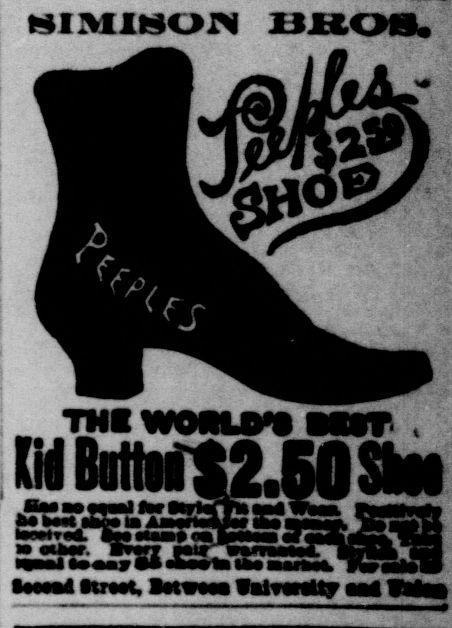

In [8]:
example=train_data[89]['image']
example

In [9]:
labels=train_data.features['label'].names
labels

['text-only', 'illustrations']

In [10]:
label2id, id2label=dict(), dict()

for i, label in enumerate(labels):
    label2id[label]=i
    id2label[i]=label

In [11]:
id2label

{0: 'text-only', 1: 'illustrations'}

In [12]:
label2id

{'text-only': 0, 'illustrations': 1}

In [13]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

2024-04-22 07:52:19.977481: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 07:52:19.977602: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 07:52:20.127071: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [14]:
checkpoint='google/vit-base-patch16-224'

processor=ViTFeatureExtractor.from_pretrained(checkpoint, )
processor

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTFeatureExtractor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [15]:
class ImageProcessor:
    def __init__(self, processor):
        self.transform = transforms.Compose([
            self.convert_to_rgb,
            transforms.Resize((processor.size['height'], processor.size['width'])),
            transforms.ToTensor(),
            transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
        ])

    def convert_to_rgb(self, pil_image):
        return pil_image.convert('RGB')

    def __call__(self, example):
        example['image'] = [self.transform(pil_image) for pil_image in example['image']]
        return example

In [16]:
train_data.set_transform(ImageProcessor(processor))
test_data.set_transform(ImageProcessor(processor))

In [17]:
e=test_data[4]['image']
e

tensor([[[ 0.7098,  0.4824,  0.4824,  ...,  0.7490,  0.7647,  0.7647],
         [ 0.6471,  0.3098,  0.3412,  ...,  0.3255,  0.3569,  0.4118],
         [ 0.7333,  0.5373,  0.5216,  ..., -0.7882, -0.7882, -0.7490],
         ...,
         [ 0.7804,  0.7569,  0.7804,  ...,  0.8039,  0.8039,  0.8039],
         [ 0.4039,  0.0824,  0.1137,  ...,  0.8039,  0.7961,  0.7961],
         [-0.0824, -0.7569, -0.7725,  ...,  0.7961,  0.7961,  0.7961]],

        [[ 0.7098,  0.4824,  0.4824,  ...,  0.7490,  0.7647,  0.7647],
         [ 0.6471,  0.3098,  0.3412,  ...,  0.3255,  0.3569,  0.4118],
         [ 0.7333,  0.5373,  0.5216,  ..., -0.7882, -0.7882, -0.7490],
         ...,
         [ 0.7804,  0.7569,  0.7804,  ...,  0.8039,  0.8039,  0.8039],
         [ 0.4039,  0.0824,  0.1137,  ...,  0.8039,  0.7961,  0.7961],
         [-0.0824, -0.7569, -0.7725,  ...,  0.7961,  0.7961,  0.7961]],

        [[ 0.7098,  0.4824,  0.4824,  ...,  0.7490,  0.7647,  0.7647],
         [ 0.6471,  0.3098,  0.3412,  ...,  0

In [18]:
training_loader=DataLoader(train_data, shuffle=True)
training_loader

In [19]:
testing_loader=DataLoader(test_data, shuffle=True)
testing_loader

In [20]:
model=ViTForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
criterion=torch.nn.CrossEntropyLoss()

In [22]:
learning_rate=1e-5
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
from datasets import load_metric

metrics=load_metric('accuracy')

/tmp/ipykernel_34/951723681.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metrics=load_metric('accuracy')
/opt/conda/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [24]:
num_epochs=5
num_steps=num_epochs*len(training_loader)
num_steps

2195

In [25]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [26]:
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [37]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, training_loader, testing_loader = accelerator.prepare(
    model, optimizer, training_loader, testing_loader
)

In [28]:
from huggingface_hub import notebook_login

notebook_login()

In [29]:
from huggingface_hub import Repository, get_full_repo_name

model_name = "ad_recognition"
repo_name = get_full_repo_name(model_name)
repo_name

'KameshRsk/ad_recognition'

In [36]:
output_dir = "/kaggle/working/ad_recognition"
repo = Repository(output_dir, clone_from=repo_name)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/KameshRsk/ad_recognition into local empty directory.


In [38]:
from tqdm.auto import tqdm

progress=tqdm(range(num_steps))

for epoch in range(num_epochs):

    model.train()
    for batch in training_loader:
        inputs=batch['image'].to(device)
        labels=batch['label'].to(device)

        output=model(pixel_values=inputs).logits

        loss=criterion(output, labels)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        progress.update(1)

    model.eval()
    for batch in testing_loader:
        inputs=batch['image'].to(device)
        labels=batch['label'].to(device)

        with torch.no_grad():
            output=model(pixel_values=inputs).logits

        preds=output.argmax(dim=-1)
        
        preds = accelerator.gather(preds)
        labels = accelerator.gather(labels)

        metrics.add_batch(predictions=preds, references=labels)

    result=metrics.compute()

    print(f"Epoch:{epoch+1} | Accuracy:{result['accuracy']:.2f}")
    
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        processor.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch}", blocking=False
        )

  0%|          | 0/2195 [00:00<?, ?it/s]

Epoch:1 | Accuracy:0.89
Epoch:2 | Accuracy:0.90
Epoch:3 | Accuracy:0.90
Epoch:4 | Accuracy:0.90
Epoch:5 | Accuracy:0.90
